# Time series forecasting

### Table of Contents: <a id='toc'><a/>
* [Importing the Libraries & Data](#import)
<br><br>
* [Some Leyman EDA](#eda)
<br><br>
* [Model Selection](#model_selection)
<br><br>
* [Holt'z Winter](#holtz_winter)
  * [Some interesting Formulaes](#holtz_winter_formulae)
  * [Additive Model](#ets_add)
  * [Multiplicative Model with Dampness](#ets_mult)
<br><br>
* [ARIMA](#arma)
  * [ARIMA Model](#arima)
  * [SARIMA Model](#sarima)
<br><br>
* [STL Decompose](#stl)
  * [Decomposition](#decomp)
  * [Leveraging ARIMA](#stl_arima)
<br><br>
* [FB prophet](#prophet)
  * [Multiplicative Model](#fb_mult)
  * [Additive Model](#fb_add)
<br><br>
* [Conclusion](#conclusion)

-----------------

## Importing Libraries <a id='import'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mpld
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\Roderick\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
consumption = pd.read_csv('Electricity Consumption.csv')

In [3]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [4]:
consumption.head(5)

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [5]:
consumption['DATE'] = pd.to_datetime(consumption.DATE, format='%m/%d/%Y')
consumption.set_index(consumption.DATE, inplace=True)
consumption = consumption.asfreq(freq='MS')
consumption.head()

,DATE,Electricty_Consumption_in_TW
DATE,,
1973-01-01,1973-01-01,35.9728
1973-02-01,1973-02-01,36.1334
1973-03-01,1973-03-01,35.0625
1973-04-01,1973-04-01,33.8416
1973-05-01,1973-05-01,33.5107


In [6]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Freq: MS
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.1 KB


In [7]:
consumption.rename(columns={'DATE': 'Date', 'Electricty_Consumption_in_TW': 'Consumption_TW'}, inplace=True)
consumption['year'] = consumption.Date.dt.year
consumption['month'] = consumption.Date.dt.month

In [8]:
consumption.tail()

,Date,Consumption_TW,year,month
DATE,,,,
2019-05-01,2019-05-01,97.5860,2019,5
2019-06-01,2019-06-01,110.8580,2019,6
2019-07-01,2019-07-01,122.1014,2019,7
2019-08-01,2019-08-01,121.7765,2019,8
2019-09-01,2019-09-01,109.7190,2019,9


In [9]:
ts = consumption.Consumption_TW

In [10]:
ts.head()

DATE
1973-01-01    35.9728
1973-02-01    36.1334
1973-03-01    35.0625
1973-04-01    33.8416
1973-05-01    33.5107
Freq: MS, Name: Consumption_TW, dtype: float64

# Some Leyman EDA  <a id='eda'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [11]:
consumption.pivot_table(values='Consumption_TW', index='year', columns='month')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1973,35.9728,36.1334,35.0625,33.8416,33.5107,36.4823,39.1412,41.4137,40.1639,37.1133,37.0248,38.4341
1974,40.7455,39.8340,37.9408,36.3004,36.5293,40.8899,44.3563,45.9240,44.4555,40.6417,39.4901,38.9068
1975,40.0956,39.6944,38.3040,36.8939,37.5668,40.3832,44.9671,46.1853,43.3001,40.3836,39.8092,42.0597
1976,43.4099,42.5826,40.9244,39.3533,39.0766,42.4851,46.3693,48.1945,45.1688,41.1880,40.8431,44.1468
1977,47.6892,44.8505,42.8557,41.0177,40.7201,45.0610,48.9685,50.1898,47.5982,44.0684,45.4267,49.3447
1978,52.9153,49.9488,46.1749,43.6652,44.5402,48.9480,53.8292,54.1182,50.9980,46.3711,45.3267,49.0027
1979,53.3617,51.6279,47.8264,43.7935,44.8591,50.3292,54.3579,55.9197,53.5776,48.7261,48.2585,51.3008
1980,56.5838,55.6802,50.4428,46.8693,46.0886,49.7595,53.8273,56.2272,52.5737,48.8947,48.4081,50.6659
1981,53.5867,53.5461,51.0708,46.9172,45.5795,50.0235,57.1384,59.5376,56.1935,50.3249,49.2234,52.8176


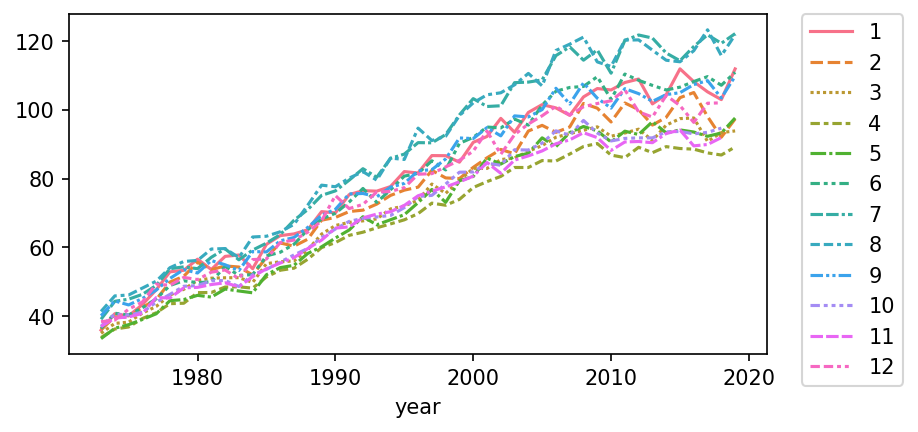

In [12]:
#Long to wide data
fig, ax = plt.subplots(figsize=[6,3], dpi=150)
sns.lineplot(ax=ax, data=consumption.pivot_table(values='Consumption_TW', index='year', columns='month'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

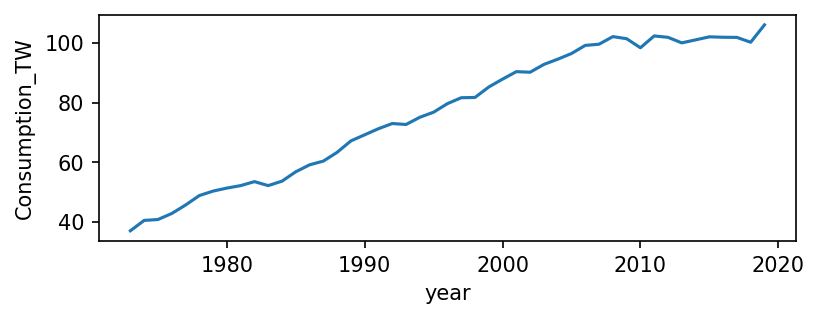

In [13]:
# Examining a pattern at a very low level of granularity
fig, ax = plt.subplots(figsize=[6,2], dpi=150)
sns.lineplot(ax=ax, data=consumption.groupby('year').Consumption_TW.mean())
plt.show()

### There seems to be a plateau towards the end. Lets magnify 🔎 the second half of the Time-Series

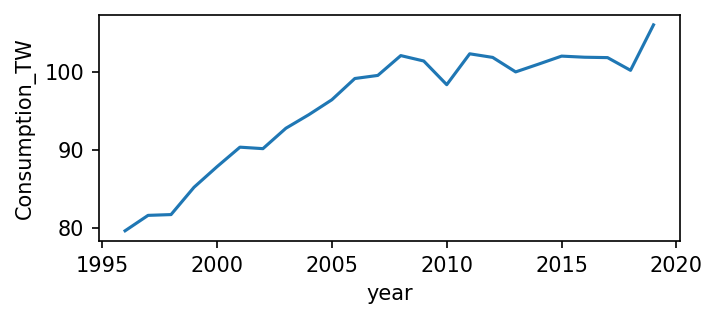

In [14]:
# Examining a pattern at a very low level of granularity
fig, ax = plt.subplots(figsize=[5,2], dpi=150)
sns.lineplot(ax=ax, data=consumption.query('year > 1995').groupby('year').Consumption_TW.mean())
plt.show()

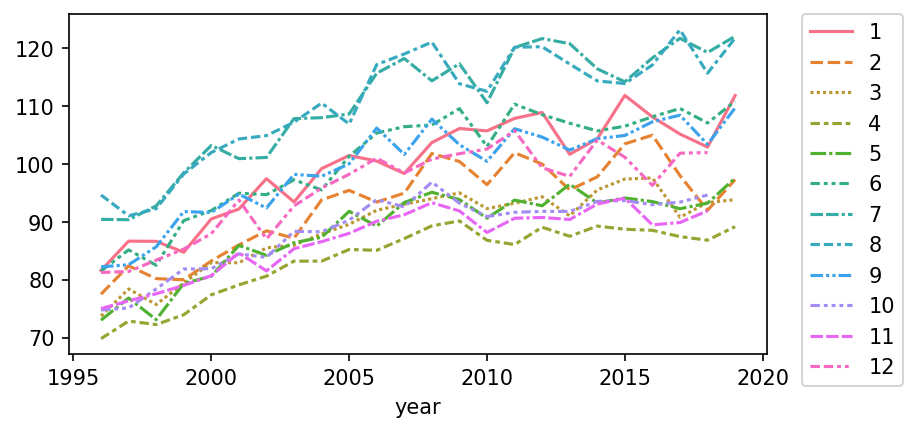

In [15]:
#Long to wide data
fig, ax = plt.subplots(figsize=[6,3], dpi=150)
sns.lineplot(ax=ax, data=consumption.query('year > 1995').pivot_table(values='Consumption_TW', index='year', columns='month'))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## The violation of the upward trend 2007 onwards is worth noting

In [16]:
consumption.pivot_table(values='Consumption_TW', index='month', columns='year')

year,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
month,,,,,,,,,,,,,,,,,,,,,
1,35.9728,40.7455,40.0956,43.4099,47.6892,52.9153,53.3617,56.5838,53.5867,57.4002,...,105.7413,107.8967,108.9151,101.6890,104.3752,111.8708,108.1515,105.1879,102.9398,111.8520
2,36.1334,39.8340,39.6944,42.5826,44.8505,49.9488,51.6279,55.6802,53.5461,54.6248,...,96.4428,101.9572,100.0117,95.5366,97.7907,103.4990,104.9900,98.0069,92.0095,97.3261
3,35.0625,37.9408,38.3040,40.9244,42.8557,46.1749,47.8264,50.4428,51.0708,51.1896,...,92.2986,93.2285,94.3484,91.0434,95.5280,97.4134,97.5969,90.8029,93.3526,93.8406
4,33.8416,36.3004,36.8939,39.3533,41.0177,43.6652,43.7935,46.8693,46.9172,48.4958,...,86.8242,86.0874,89.0821,87.5189,89.2783,88.7323,88.5477,87.4594,86.8386,89.1873
5,33.5107,36.5293,37.5668,39.0766,40.7201,44.5402,44.8591,46.0886,45.5795,47.9140,...,90.6389,93.7706,92.7937,96.5166,93.2729,94.1360,93.5168,92.2811,93.2361,97.5860
6,36.4823,40.8899,40.3832,42.4851,45.0610,48.9480,50.3292,49.7595,50.0235,54.5292,...,103.0377,110.3572,108.5421,107.0627,105.7336,106.5504,108.1813,109.6104,107.1009,110.8580
7,39.1412,44.3563,44.9671,46.3693,48.9685,53.8292,54.3579,53.8273,57.1384,59.5975,...,110.6045,120.1457,121.6974,120.8149,116.4651,114.2235,118.3568,121.7478,119.2874,122.1014
8,41.4137,45.9240,46.1853,48.1945,50.1898,54.1182,55.9197,56.2272,59.5376,59.6727,...,112.5792,120.2087,120.2822,117.2932,114.3700,113.9230,117.1375,123.2163,115.7108,121.7765
9,40.1639,44.4555,43.3001,45.1688,47.5982,50.9980,53.5776,52.5737,56.1935,54.9644,...,100.4701,106.1109,104.6692,102.4185,104.3899,104.9454,107.3046,108.4514,103.4070,109.7190


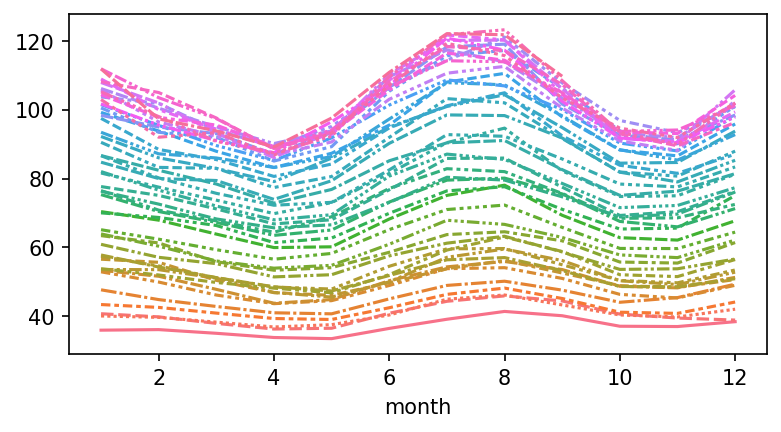

In [17]:
# Omitting the long list of legends
fig, ax = plt.subplots(figsize=[6,3], dpi=150)
sns.lineplot(ax=ax, data=consumption.pivot_table(values='Consumption_TW', index='month', columns='year'), legend=False)
plt.show()

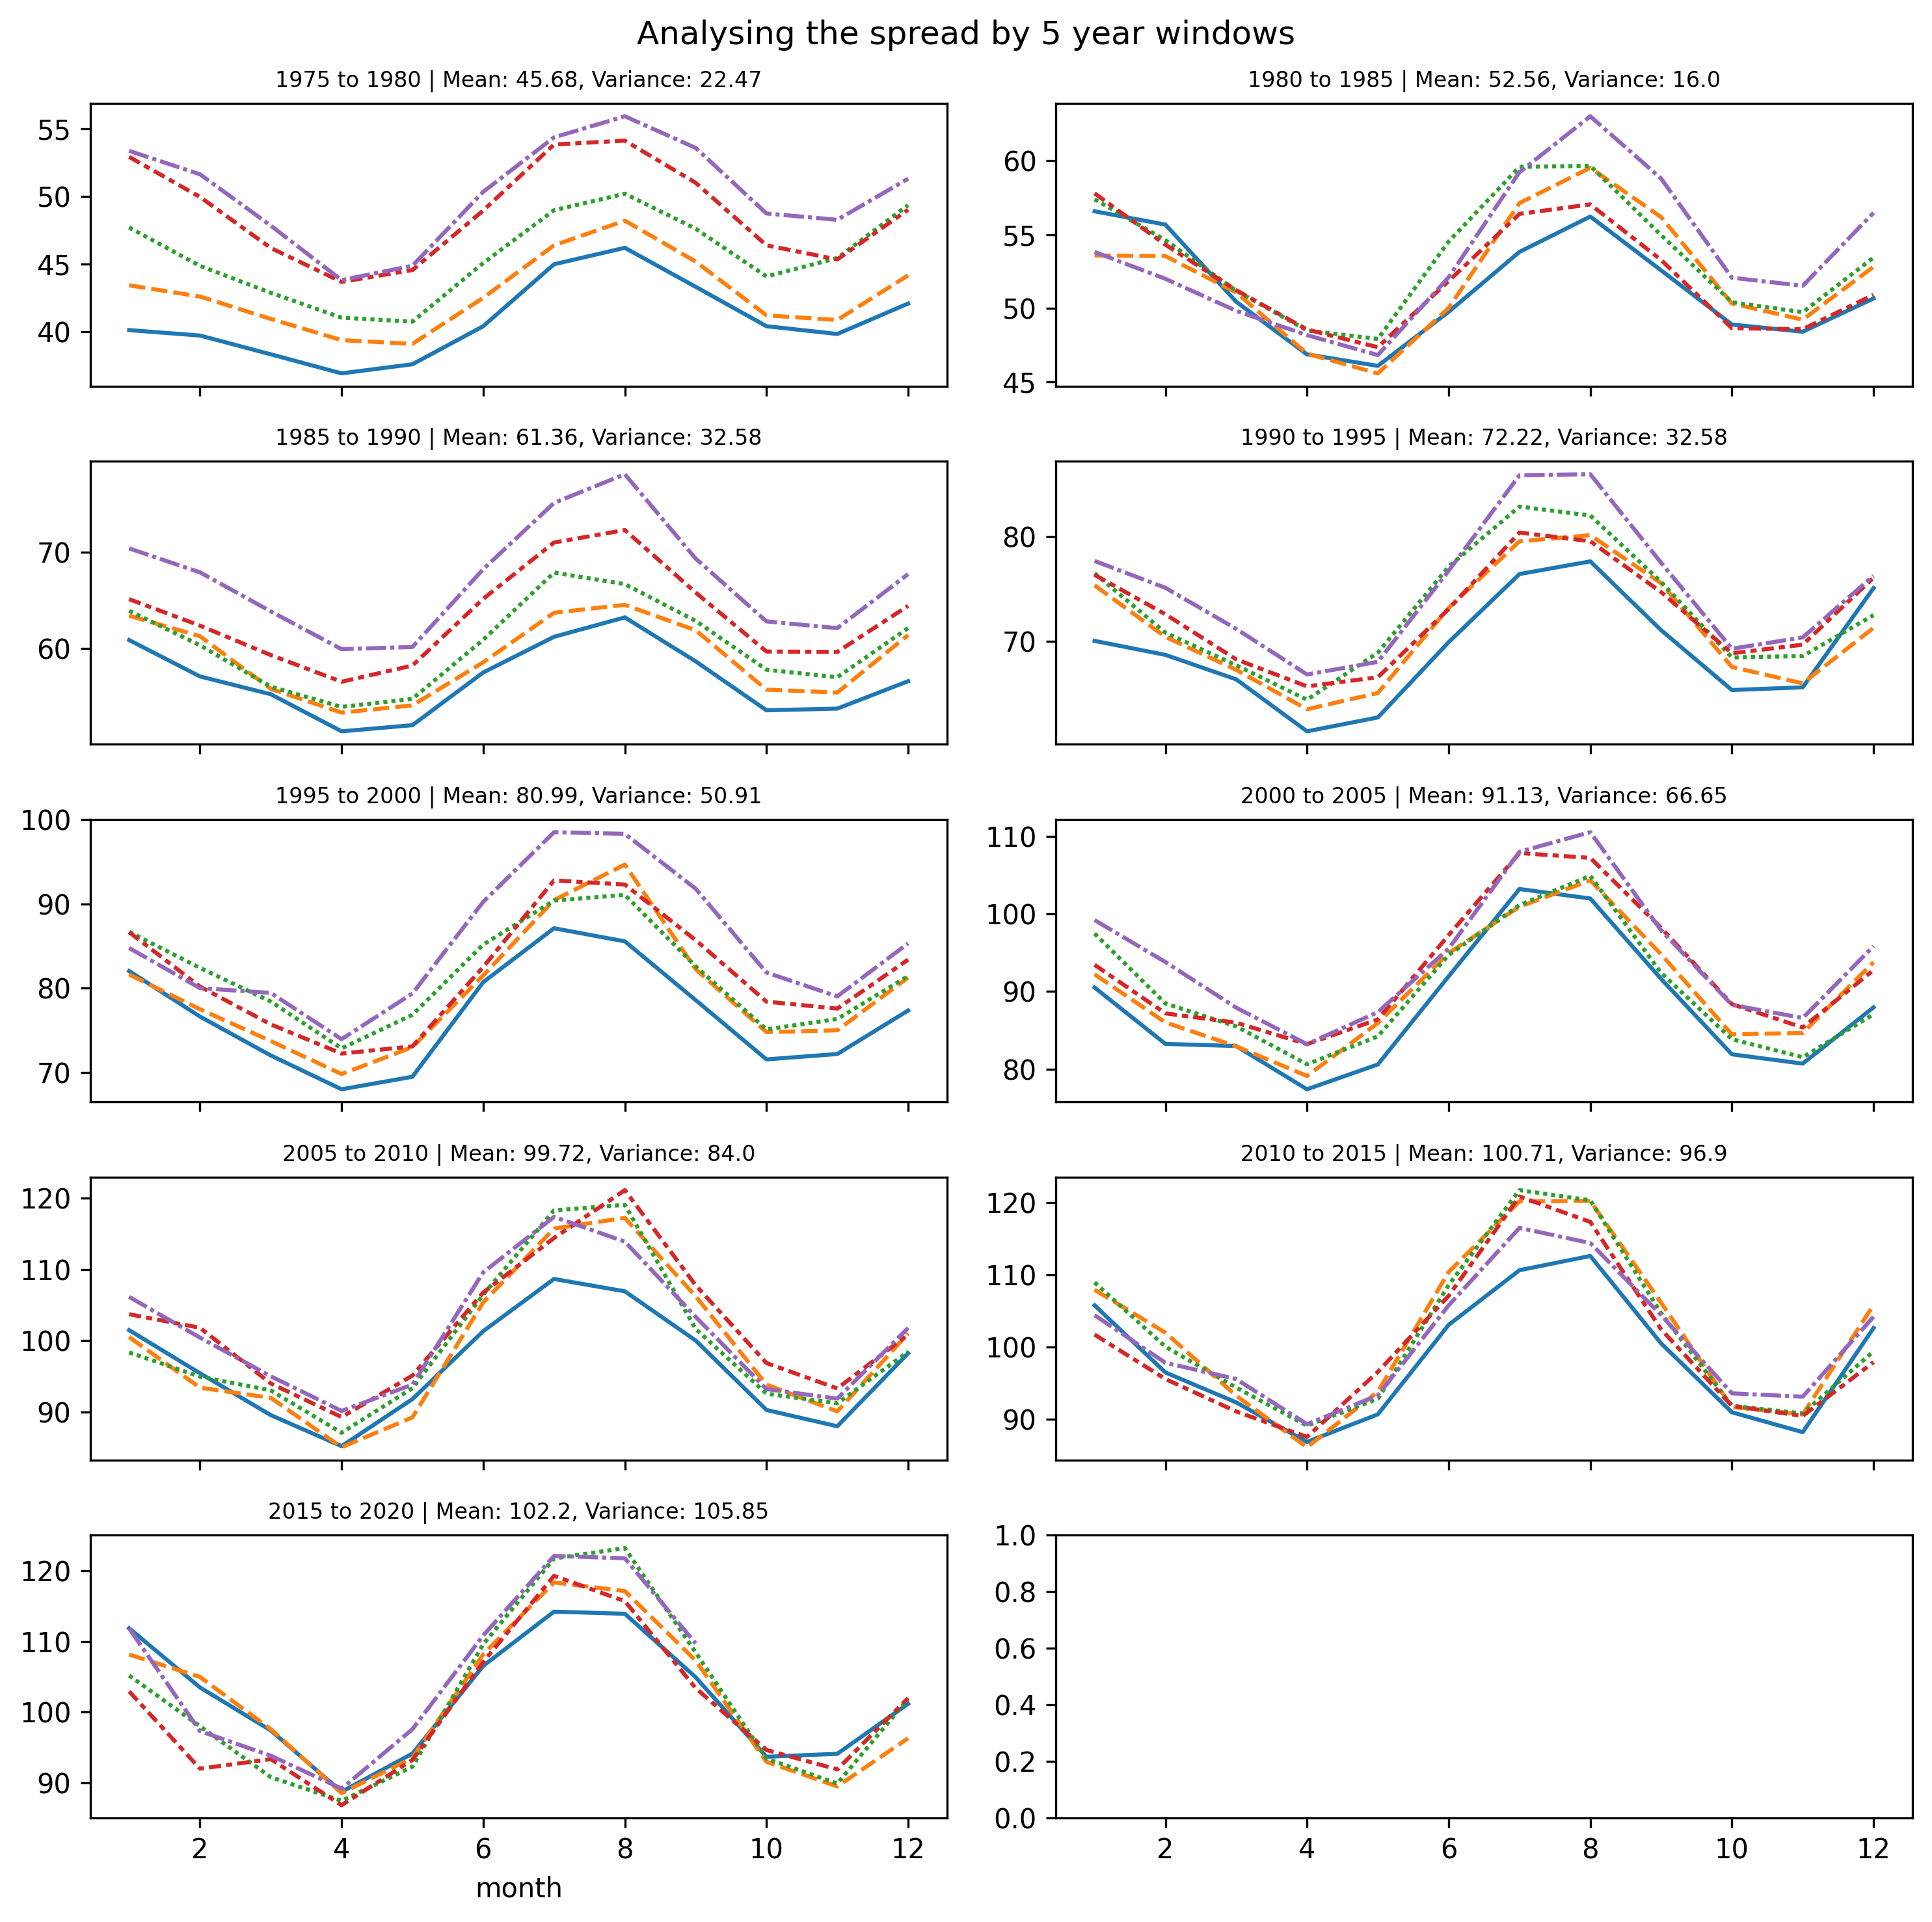

In [18]:
# Omitting the long list of legends
def split_by_years():
    years = 5
    fig, axes = plt.subplots(5, 2, figsize=(10,10), dpi=300, sharex=True)
    fig.suptitle('Analysing the spread by 5 year windows')
    for i in [*range(1975,2019,years)]:
        year_range = 'year >= {} & year < {}'.format(i,i+years)
        df = consumption.query(year_range).pivot_table(values='Consumption_TW', index='month', columns='year')
        x=df.to_numpy().flatten()
        ax_indx_x = int(((i-1975)/5)/2)
        ax_indx_y = int(((i-1975)/5)%2)
        sns.lineplot(ax = axes[ax_indx_x, ax_indx_y], data=df, legend=False)
        axes[ax_indx_x, ax_indx_y].set_title("{} to {} | Mean: {}, Variance: {}".format(i,i+years, x[~np.isnan(x)].mean().round(2),x[~np.isnan(x)].var().round(2)), fontsize = 8)
    plt.tight_layout()
split_by_years()

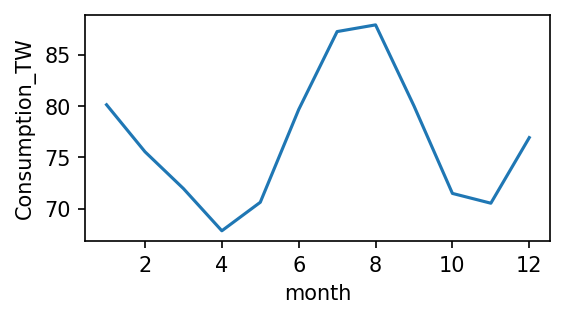

In [19]:
# To have a look at the aggregated seasonality accross a year

fig, ax = plt.subplots(figsize=[4,2], dpi=150)
sns.lineplot(ax=ax, data=consumption.groupby('month').Consumption_TW.mean())
plt.show()

# Observations:
- There's an evident Trend & Seasonality.
- The trend suddenly dampens, 2007 onwards.
- The dispersion increases, moving forward along the timeline.

# Model Selection <a id='model_selection'></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [20]:
# Train Test Split

print("Total data points: ",consumption.shape[0])
train = consumption.Consumption_TW.iloc[:int(consumption.shape[0]*0.8)]
print("Data points for Training: ",train.size)
test = consumption.Consumption_TW.iloc[int(consumption.shape[0]*0.8):]
print("Data points for Testing: ",test.size)

Total data points:  561
Data points for Training:  448
Data points for Testing:  113


In [21]:
from sklearn import metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error)
from statsmodels.tools.eval_measures import rmspe

In [22]:
# A function to calculate the error metrics

error_metrics = pd.DataFrame(columns=['Method', 'MSE', 'RMSPE', 'MAPE'])

def get_error_metrics(method, y_true, y_pred, error_metrics):
    mse = mean_squared_error(y_true, y_pred)
    rmspe_ = rmspe(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    details = {
    'Method' : method,
    'MSE' : mse,
    'RMSPE' : rmspe_,
    'MAPE' : mape}
    error_metrics = error_metrics.append(details, ignore_index=True)
    return error_metrics

---

## Holt's Winter <a id="holtz_winter"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>
    
### A few important formulae:

#### simple exponential smoothing <a id="holtz_winter_formulae"></a>
### $$\hat{y}_{T+1|T}=\sum_{j=0} ^{T-1} \alpha(1-\alpha)^jy_{T-j}+(1-\alpha)^{T}l_{0}$$
### $$\mathrm{Forecast \ equation:}\ \hat{y}_{t+h|t}=l_{t}$$
### $$\mathrm{Smoothing \ equation:}\ l_{t}=\alpha y_t + (1-\alpha)l_{t-1}$$

---

#### Holt’s linear trend method
### $$\mathrm{Forecast \ equation:}\ \hat{y}_{t+h|t}=l_{t}+h b_t$$
### $$\mathrm{Level \ equation:}\ l_{t}=\alpha y_t + (1-\alpha)(l_{t-1}+b_{t-1})$$
### $$\mathrm{Trend \ equation:}\ b_{t}=b^*(l_{t}-l_{t-1})+(1-b^*)b_{t-1} $$

---
#### Damped trend methods

### $$\mathrm{Forecast \ equation:}\ \hat{y}_{t+h|t}=l_{t}+(\phi + \phi^2 + \phi^3 + ... + \phi^h) b_t$$
### $$\mathrm{Level \ equation:}\ l_{t}=\alpha y_t + (1-\alpha)(l_{t-1}+\phi b_{t-1})$$
### $$\mathrm{Trend \ equation:}\ b_{t}=b^*(l_{t}-l_{t-1})+(1-b^*)\phi b_{t-1} $$

----
#### Holt-Winters’ additive method

### $$\hat{y}_{t+h|t}=l_{t}+h b_t + s_{t+h-m(k+1)}$$
### $$l_{t}=\alpha (y_t - s_{t-m})+ (1-\alpha)(l_{t-1}+b_{t-1})$$
### $$b_{t}=b^*(l_{t}-l_{t-1})+(1-b^*)b_{t-1} $$
### $$s_{t}=\gamma(y_{t}-l_{t-1}-b_{t-1})+(1-\gamma)s_{t-m} $$
---
#### Holt-Winters’ multiplicative method

### $$\hat{y}_{t+h|t}=(l_{t}+h b_t)s_{t+h-m(k+1)}$$
### $$l_{t}=\alpha \frac{y_t} {s_{t-m}}+ (1-\alpha)(l_{t-1}+b_{t-1})$$
### $$b_{t}=b^*(l_{t}-l_{t-1})+(1-b^*)b_{t-1} $$
### $$s_{t}=\gamma \frac{y_{t}}{l_{t-1}+b_{t-1}}+(1-\gamma)s_{t-m} $$
---

#### Holt-Winters’ damped method

### $$\hat{y}_{t+h|t}=[l_{t}+(\phi + \phi^2 + \phi^3 + ... + \phi^h) b_t]s_{t+h-m(k+1)}$$
### $$l_{t}=\alpha \frac{y_t} {s_{t-m}}+ (1-\alpha)(l_{t-1}+ \phi b_{t-1})$$
### $$b_{t}=b^*(l_{t}-l_{t-1})+(1-b^*)\phi b_{t-1} $$
### $$s_{t}=\gamma \frac{y_{t}}{l_{t-1}+\phi b_{t-1}}+(1-\gamma)s_{t-m} $$

#### Additive model <a id="ets_add"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

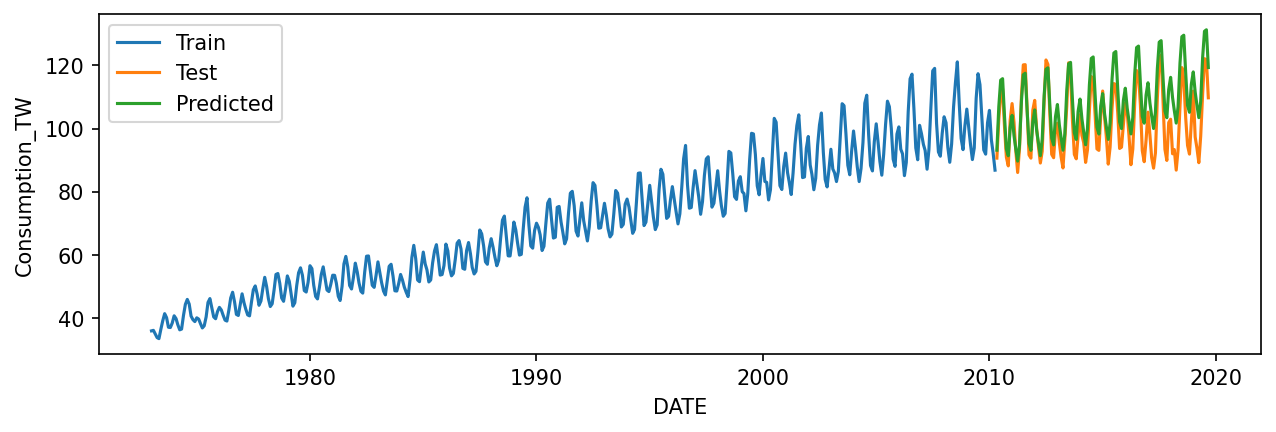

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Training the model
model = ExponentialSmoothing(train,trend='additive',seasonal='additive',seasonal_periods=12).fit()

fig, ax = plt.subplots(figsize=[10,3], dpi=150)
sns.lineplot(ax=ax, data=train, label="Train")
sns.lineplot(ax=ax, data=test, label="Test")
sns.lineplot(ax=ax, data=model.forecast(113), label="Predicted")
plt.show()

In [24]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:           Consumption_TW   No. Observations:                  448
Model:             ExponentialSmoothing   SSE                           1320.498
Optimized:                         True   AIC                            516.275
Trend:                         Additive   BIC                            581.952
Seasonal:                      Additive   AICC                           517.870
Seasonal Periods:                    12   Date:                 Mon, 24 Apr 2023
Box-Cox:                          False   Time:                         23:32:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3929321                alpha                 True
smoothing_trend          

In [25]:
error_metrics = get_error_metrics('Holtz winter Additive', test, model.forecast(113), error_metrics)

#### Multiplicative model with Dampness <a id="ets_mult"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

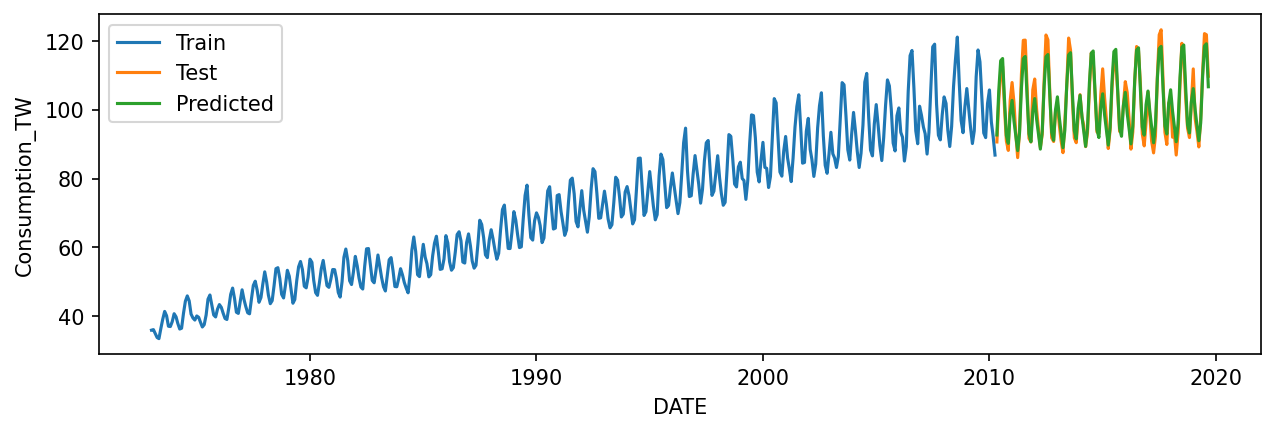

In [26]:
# Training the model
model = ExponentialSmoothing(train,trend='additive',seasonal='multiplicative', damped_trend=True, seasonal_periods=12).fit()

fig, ax = plt.subplots(figsize=[10,3], dpi=150)
sns.lineplot(ax=ax, data=train, label="Train")
sns.lineplot(ax=ax, data=test, label="Test")
sns.lineplot(ax=ax, data=model.forecast(113), label="Predicted")
plt.show()

In [27]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:           Consumption_TW   No. Observations:                  448
Model:             ExponentialSmoothing   SSE                           1182.020
Optimized:                         True   AIC                            468.644
Trend:                         Additive   BIC                            538.425
Seasonal:                Multiplicative   AICC                           470.420
Seasonal Periods:                    12   Date:                 Mon, 24 Apr 2023
Box-Cox:                          False   Time:                         23:32:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4413462                alpha                 True
smoothing_trend          

In [28]:
error_metrics = get_error_metrics('Holtz winter Multiplicative Damped', test, model.forecast(113), error_metrics)

In [29]:
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.82259,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.27769,0.022729


## ARMA Model <a id="arma"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>    
#### Checking for Stationarity

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

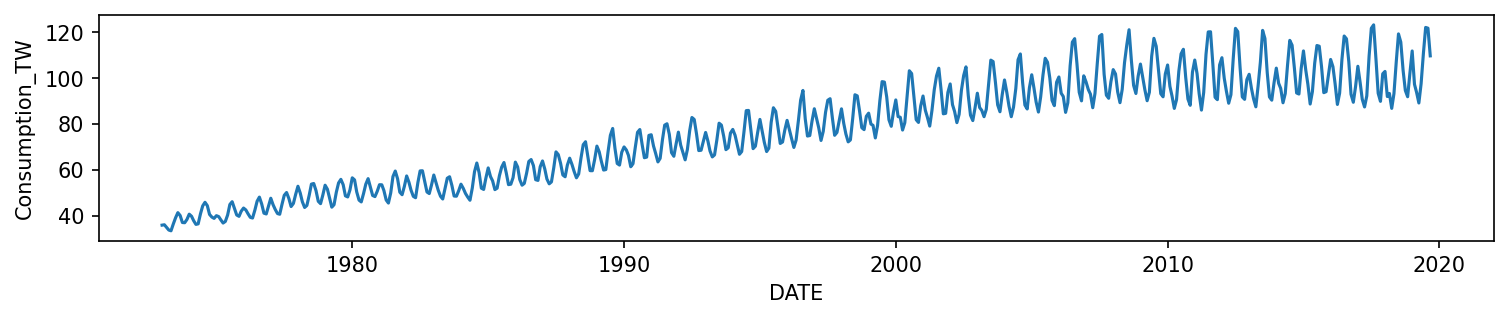

In [31]:
fig, ax = plt.subplots(figsize=[12,2], dpi=150)
sns.lineplot(ax=ax, data=ts)
plt.show()

In [32]:
# Although the absence of Stationarity is clear, let's confirm it with the adfuller test
ADF_result = adfuller(ts)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.7405933729832488
p-value: 0.4103281604468657


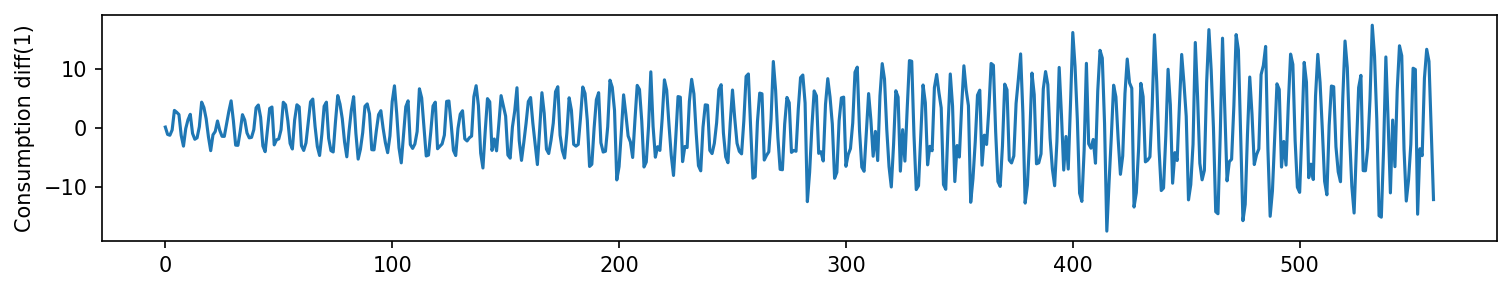

ADF Statistic: -7.941665363981186
p-value: 3.3013438021514486e-12


In [33]:
# Let's try taking the first difference
fig, ax = plt.subplots(figsize=[12,2], dpi=150)
sns.lineplot(ax=ax, data=np.diff(ts,1))
plt.ylabel("Consumption diff(1)")
plt.show()

ADF_result = adfuller(np.diff(ts,1))

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

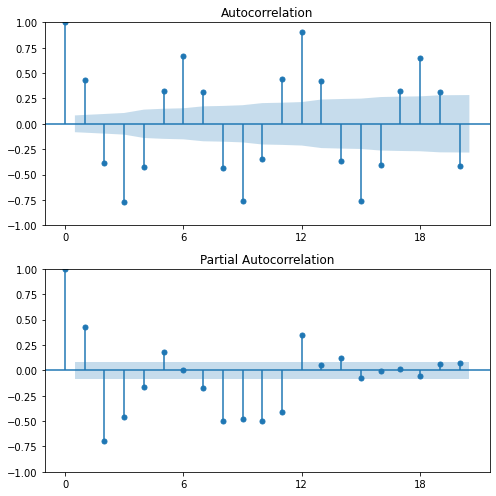

In [34]:
# Since we have a large negative ADF statistic and a p-value that much smaller than 0.05, 
# we can conclude that our process is stationary

# Let's have a look at the ACF & PACF plots

fig, ax = plt.subplots(2, 1, figsize=(7,7))

plot_acf(np.diff(ts,1), ax=ax[0], lags=20);
ax[0].set_xticks([0,6,12,18])
plot_pacf(np.diff(ts,1), ax=ax[1], lags=20);
ax[1].set_xticks([0,6,12,18])

plt.tight_layout()
plt.show()

##### The graph peaks twice a year(once every 6 months) hence the sinusoidal pattern after an interval of 6 
##### Moreover since there is not clear cutoff between significantand non-significant coefficients in both the ACF and PACF plot we can conclude that we have an ARMA(p,q) process

### Autoregressive moving average process: ARMA(p,q)
### $$y_t = C + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_py_{t-p} + \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q} $$
### ARIMA(I: 'Integration') is an extention of ARMA that doesn't assume stationarity, instead uses the parameter "d" to difference & later Integrate the process, in the given case d=1, although it can be iterated over several combinations

## ARIMA Model <a id="arima"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [35]:
# A function to iterate several runs of the ARIMA with different parameters model and record the value of AIC

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [36]:
# Finding the most efficient ARIMA model
p = range(0, 6, 1)
q = range(0, 6, 1)
d = 1

ARIMA_order_list = list(product(p, q))

# ARIMA_result_df = optimize_ARIMA(train, ARIMA_order_list, d)
# ARIMA_result_df.head()

In [37]:
ARIMA_model = SARIMAX(train, order=(4,1,5), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         Consumption_TW   No. Observations:                  448
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -1036.602
Date:                Mon, 24 Apr 2023   AIC                           2093.203
Time:                        23:32:34   BIC                           2134.229
Sample:                    01-01-1973   HQIC                          2109.377
                         - 04-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7172      0.087      8.219      0.000       0.546       0.888
ar.L2         -0.0429      0.075     -0.571      0.568      -0.190       0.104
ar.L3         -0.9528      0.076    -12.609      0.0

C:\Users\Roderick\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


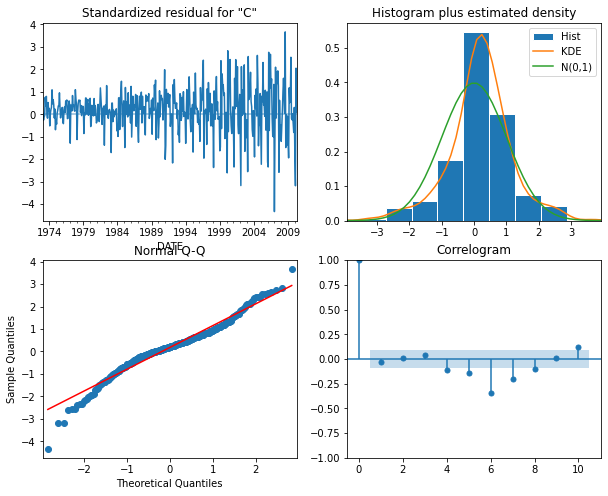

In [38]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [39]:
# All the charts above are indicative of normality in the residuals
# Still let's run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated
residuals = ARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 6, 1))

,lb_stat,lb_pvalue
1,0.286745,0.592314
2,0.318720,0.852689
3,0.488739,0.921358
4,3.308975,0.507512
5,5.992613,0.306938


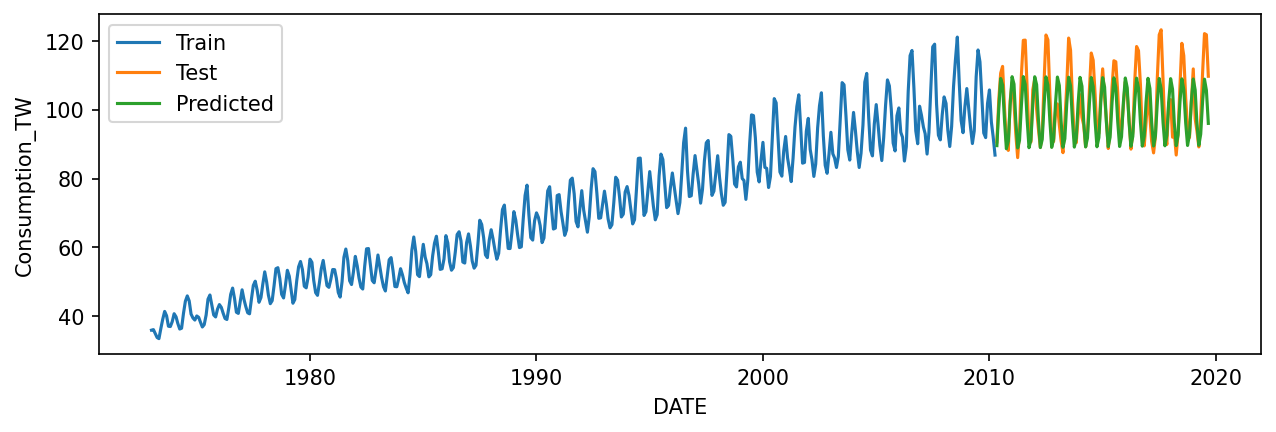

In [40]:
# The returned p-values are all greater than 0.05, we can conclude that the residuals are all uncorrelated

fig, ax = plt.subplots(figsize=[10,3], dpi=150)
sns.lineplot(ax=ax, data=train, label="Train")
sns.lineplot(ax=ax, data=test, label="Test")
sns.lineplot(ax=ax, data=ARIMA_model_fit.forecast(113), label="Predicted")
plt.show()

In [41]:
ARIMA_pred = ARIMA_model_fit.forecast(113)
error_metrics = get_error_metrics('ARIMA', test, ARIMA_pred, error_metrics)
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.822590,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.277690,0.022729
2,ARIMA,42.276840,0.595184,0.047916


## SARIMA Model <a id="sarima"></a><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [42]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [43]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 3, 1)
Qs = range(0, 3, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 6

# SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
# SARIMA_result_df.head()

In [44]:
SARIMA_model = SARIMAX(train, order=(2,1,2), seasonal_order=(2,1,2,6), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    Consumption_TW   No. Observations:                  448
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 6)   Log Likelihood                -838.214
Date:                           Mon, 24 Apr 2023   AIC                           1694.428
Time:                                   23:32:38   BIC                           1731.229
Sample:                               01-01-1973   HQIC                          1708.945
                                    - 04-01-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0549      0.168     -0.326      0.744      -0.385       0.275
ar.L2          0.3290      0.133      2.473

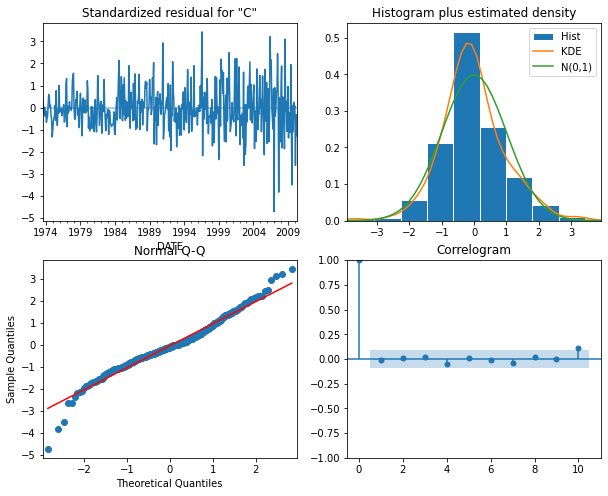

In [45]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [46]:
# All the charts above are indicative of normality in the residuals
# Still let's run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated
residuals = SARIMA_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 6, 1))

,lb_stat,lb_pvalue
1,0.362757,0.546979
2,0.371896,0.830317
3,0.409315,0.938312
4,0.662471,0.955875
5,1.899358,0.862888


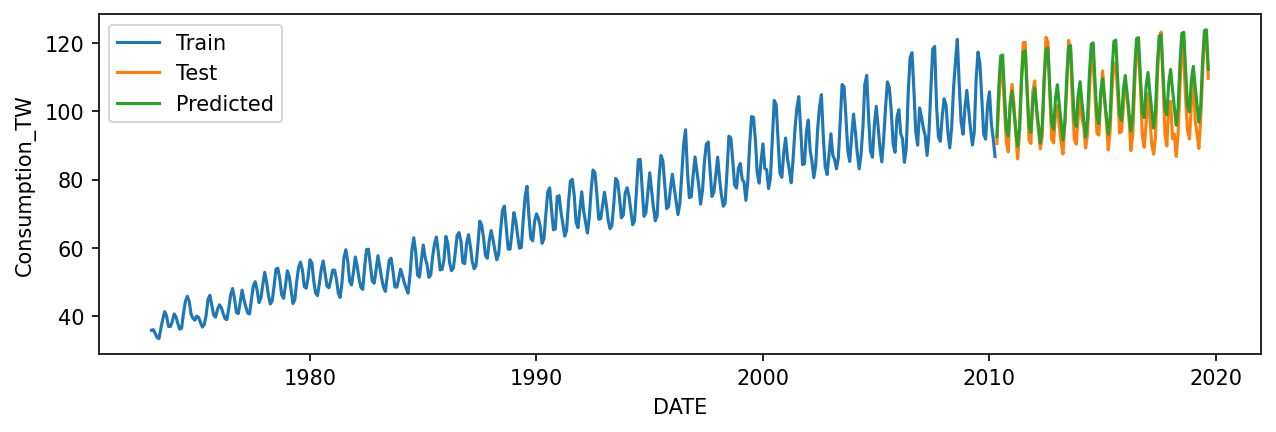

In [47]:
# The returned p-values are all greater than 0.05, we can conclude that the residuals are all uncorrelated

fig, ax = plt.subplots(figsize=[10,3], dpi=150)
sns.lineplot(ax=ax, data=train, label="Train")
sns.lineplot(ax=ax, data=test, label="Test")
sns.lineplot(ax=ax, data=SARIMA_model_fit.forecast(113), label="Predicted")
plt.show()

In [48]:
SARIMA_pred = SARIMA_model_fit.forecast(113)
error_metrics = get_error_metrics('SARIMA', test, SARIMA_pred, error_metrics)
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.822590,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.277690,0.022729
2,ARIMA,42.276840,0.595184,0.047916
3,SARIMA,26.647524,0.533783,0.044863


## STL - Seasonality Trend Loess (Locally Estimtaed Regression) <a id='stl'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

#### Decomposing <a id='decomp'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

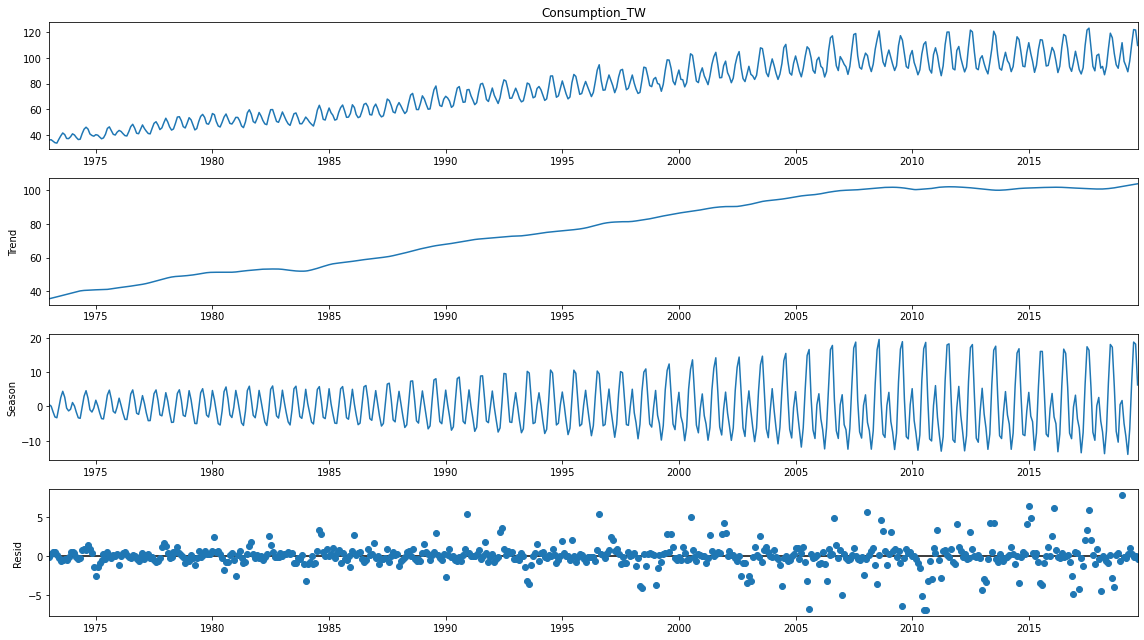

In [49]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

stl = STL(consumption.Consumption_TW, period=12,  robust=True)
res = stl.fit()
fig = res.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [50]:
decomp_output = pd.DataFrame(pd.concat([res.observed, res.trend, res.seasonal, res.resid], axis=1))
decomp_output.head()

,Consumption_TW,trend,season,resid
DATE,,,,
1973-01-01,35.9728,35.530987,0.540006,-0.098193
1973-02-01,36.1334,35.812176,0.090964,0.230260
1973-03-01,35.0625,36.095950,-1.482822,0.449372
1973-04-01,33.8416,36.382523,-3.042594,0.501671
1973-05-01,33.5107,36.671764,-3.281721,0.120657


In [51]:
decomp_output['trend_resid'] = decomp_output['trend'] + decomp_output['resid']
decomp_output.head()

,Consumption_TW,trend,season,resid,trend_resid
DATE,,,,,
1973-01-01,35.9728,35.530987,0.540006,-0.098193,35.432794
1973-02-01,36.1334,35.812176,0.090964,0.230260,36.042436
1973-03-01,35.0625,36.095950,-1.482822,0.449372,36.545322
1973-04-01,33.8416,36.382523,-3.042594,0.501671,36.884194
1973-05-01,33.5107,36.671764,-3.281721,0.120657,36.792421


#### Leveraging ARIMA <a id='stl_arima'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

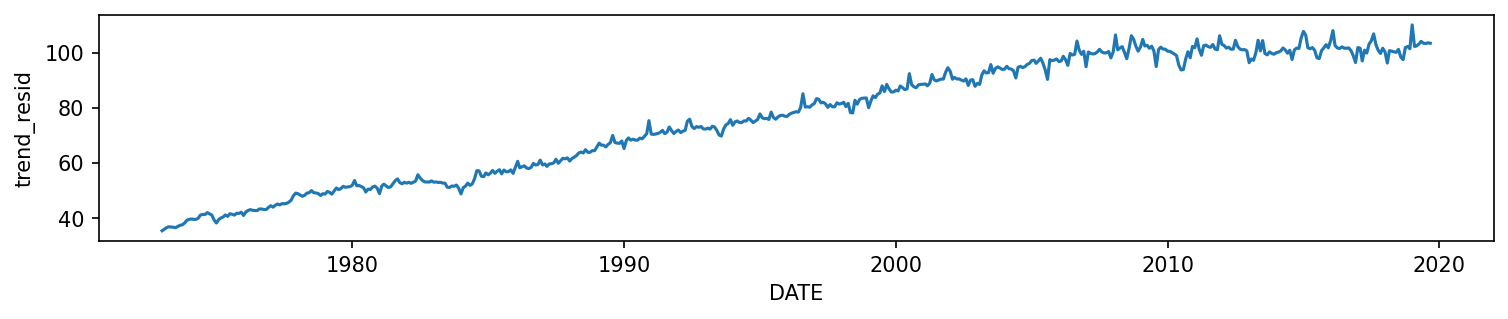

In [52]:
fig, ax = plt.subplots(figsize=[12,2], dpi=150)
sns.lineplot(ax=ax, data=decomp_output['trend_resid'])
plt.show()

In [53]:
# Checking for Stationarity
ADF_result = adfuller(decomp_output['trend_resid'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.1464678842828837
p-value: 0.22624454301708935


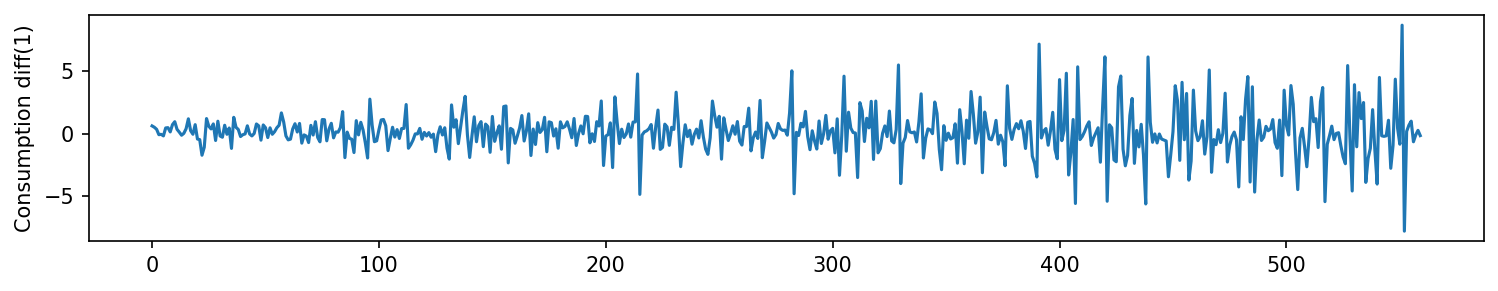

ADF Statistic: -8.5837398900608
p-value: 7.605306186980128e-14


In [54]:
# Let's try taking the first difference
fig, ax = plt.subplots(figsize=[12,2], dpi=150)
sns.lineplot(ax=ax, data=np.diff(decomp_output['trend_resid'], 1))
plt.ylabel("Consumption diff(1)")
plt.show()

ADF_result = adfuller(np.diff(decomp_output['trend_resid'], 1))

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

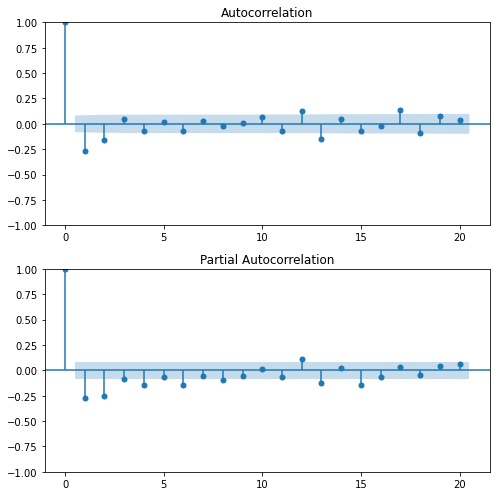

In [55]:
# Since we have a large negative ADF statistic and a p-value that much smaller than 0.05, 
# we can conclude that our process is stationary

# Let's have a look at the ACF & PACF plots

train_stl_arima = np.diff(decomp_output['trend_resid'], 1)
fig, ax = plt.subplots(2, 1, figsize=(7,7))

plot_acf(train_stl_arima, ax=ax[0], lags=20);
plot_pacf(train_stl_arima, ax=ax[1], lags=20);

plt.tight_layout()
plt.show()

In [56]:
# Finding the most efficient ARIMA model
# No significant peaks in the ACF & PACF here makes life easier

p = range(0, 3, 1)
q = range(0, 3, 1)
d = 1

ARIMA_order_list = list(product(p, q))

ARIMA_result_df = optimize_ARIMA(train_stl_arima, ARIMA_order_list, d)
ARIMA_result_df.head()

  0%|          | 0/9 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 2)",2146.546131
1,"(0, 2)",2174.966456
2,"(2, 1)",2175.143220
3,"(1, 1)",2207.680118
4,"(0, 1)",2246.434630


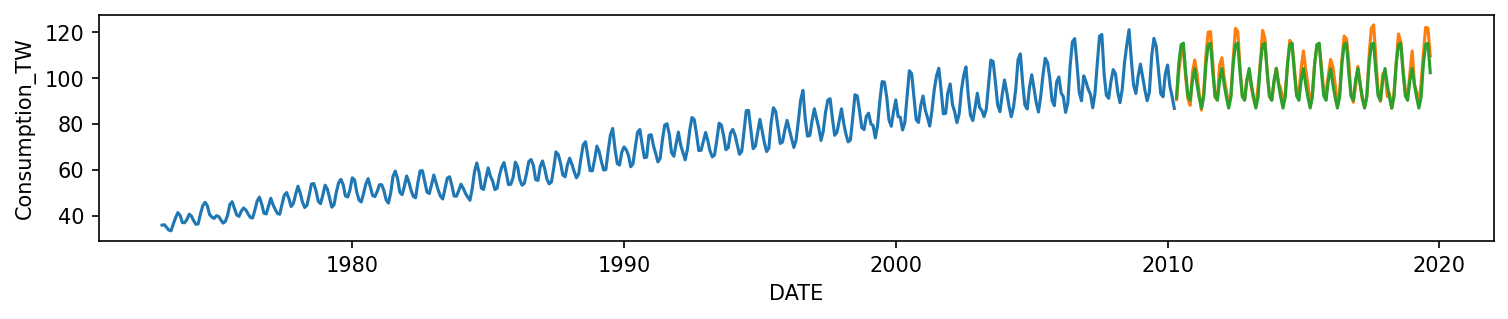

In [57]:
stlf = STLForecast(train, ARIMA, model_kwargs=dict(order=(2, 1, 2)))
stlf_res = stlf.fit()

stl_forecast = stlf_res.forecast(113)
fig, ax = plt.subplots(figsize=[12,2], dpi=150)
sns.lineplot(ax=ax, data=train)
sns.lineplot(ax=ax, data=test)
sns.lineplot(ax=ax, data=stl_forecast)
plt.show()

In [58]:
print(stlf_res.summary())

                    STL Decomposition and SARIMAX Results                     
Dep. Variable:                      y   No. Observations:                  448
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -700.407
Date:                Mon, 24 Apr 2023   AIC                           1410.814
Time:                        23:32:44   BIC                           1431.327
Sample:                    01-01-1973   HQIC                          1418.902
                         - 04-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3553      0.127     -2.800      0.005      -0.604      -0.107
ar.L2         -0.0338      0.127     -0.265      0.791      -0.284       0.216
ma.L1          0.1833      0.119      1.542      0.1

In [59]:
error_metrics = get_error_metrics('STL_arima', test, stl_forecast, error_metrics)
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.822590,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.277690,0.022729
2,ARIMA,42.276840,0.595184,0.047916
3,SARIMA,26.647524,0.533783,0.044863
4,STL_arima,12.096118,0.322460,0.025761


---
## FBProphet <a id='prophet'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [60]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

Prophet also imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column)

In [61]:
train_prophet = train.reset_index().rename(columns={'DATE': 'ds',
                        'Consumption_TW': 'y'})

train_prophet.head()

,ds,y
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


#### Multiplicative Model <a id='fb_mult'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

In [62]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
# Using the seasonal mode as Multiplicative
my_model = Prophet(seasonality_mode='multiplicative', interval_width=0.95)

In [63]:
# Fitting the model
my_model.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- In order to obtain forecasts of our time series, we must provide Prophet with a new DataFrame containing a ds column that holds the dates for which we want predictions.

- Conveniently, we do not have to concern ourselves with manually creating this DataFrame, as Prophet provides the make_future_dataframe helper function.

In [64]:
# predicting for the the next 113 months, since that is the length of our test data
future_dates = my_model.make_future_dataframe(periods=113, freq='MS')
future_dates.head()

,ds
0,1973-01-01
1,1973-02-01
2,1973-03-01
3,1973-04-01
4,1973-05-01


In [65]:
print('Length of the consumption: ',consumption.shape[0])
print('Length of the predictions Series: ',future_dates.shape[0])

Length of the consumption:  561
Length of the predictions Series:  561


In [66]:
forecast = my_model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1973-01-01,36.291186,34.725375,42.060570,36.291186,36.291186,0.051034,0.051034,0.051034,0.051034,0.051034,0.051034,0.0,0.0,0.0,38.143257
1,1973-02-01,36.472531,31.905234,39.708444,36.472531,36.472531,-0.011723,-0.011723,-0.011723,-0.011723,-0.011723,-0.011723,0.0,0.0,0.0,36.044951
2,1973-03-01,36.636326,30.920787,38.426854,36.636326,36.636326,-0.057459,-0.057459,-0.057459,-0.057459,-0.057459,-0.057459,0.0,0.0,0.0,34.531244
3,1973-04-01,36.817671,28.981632,36.393628,36.817671,36.817671,-0.110246,-0.110246,-0.110246,-0.110246,-0.110246,-0.110246,0.0,0.0,0.0,32.758657
4,1973-05-01,36.993166,30.566441,38.076932,36.993166,36.993166,-0.075206,-0.075206,-0.075206,-0.075206,-0.075206,-0.075206,0.0,0.0,0.0,34.211065


In [67]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1973-01-01,38.143257,34.725375,42.060570
1,1973-02-01,36.044951,31.905234,39.708444
2,1973-03-01,34.531244,30.920787,38.426854
3,1973-04-01,32.758657,28.981632,36.393628
4,1973-05-01,34.211065,30.566441,38.076932


Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

- **ds:** the datestamp of the forecasted value
- **yhat:** the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
- **yhat_lower:** the lower bound of our forecasts
- **yhat_upper:** the upper bound of our forecasts

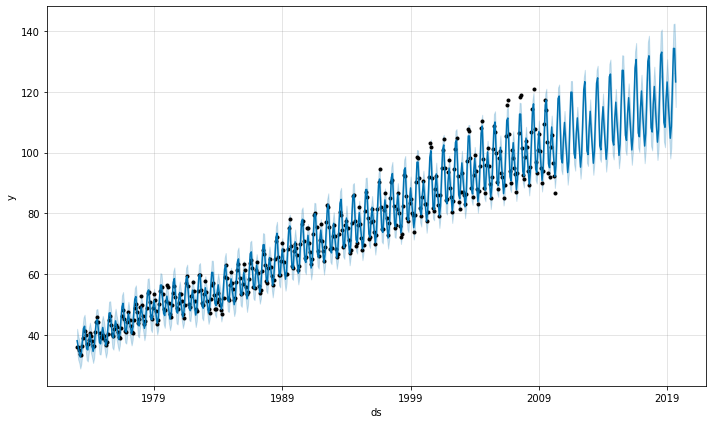

In [68]:
my_model.plot(forecast, uncertainty=True);

- Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).
- One other particularly strong feature of Prophet is its ability to return the components of our forecasts.

- This can help reveal how daily, weekly and yearly patterns of the time series contribute to the overall forecasted values.

### Plotting the forecasted components:
Table of Contents

- We can plot the trend and seasonality, components of the forecast as follows:

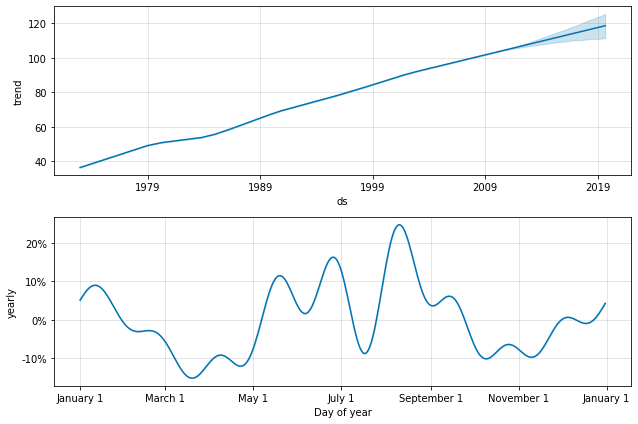

In [69]:
my_model.plot_components(forecast);

In [70]:
error_metrics = get_error_metrics('FB_prophet_multiplicative', test, forecast['yhat'][-113:], error_metrics)
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.822590,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.277690,0.022729
2,ARIMA,42.276840,0.595184,0.047916
3,SARIMA,26.647524,0.533783,0.044863
4,STL_arima,12.096118,0.322460,0.025761
5,FB_prophet_multiplicative,120.075556,1.113683,0.099623


#### Additive Model <a id='fb_add'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


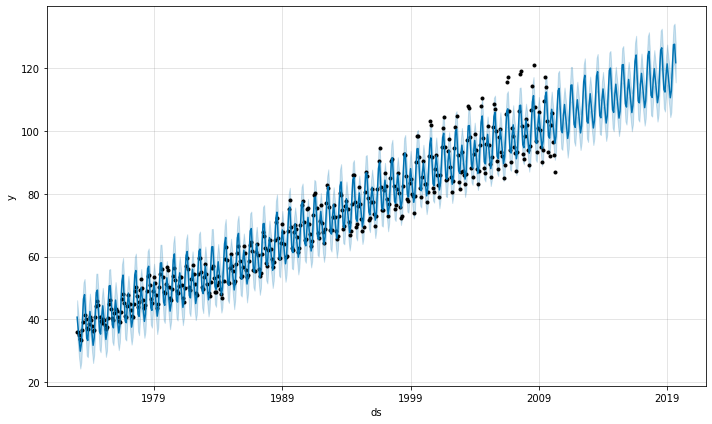

In [71]:
# Using the additive variant

my_model_add = Prophet(seasonality_mode='additive', interval_width=0.95)

# Fitting the model
my_model_add.fit(train_prophet)

# predicting for the the next 113 months, since that is the length of our test data
future_dates = my_model_add.make_future_dataframe(periods=113, freq='MS')

forecast = my_model_add.predict(future_dates)

my_model_add.plot(forecast, uncertainty=True);

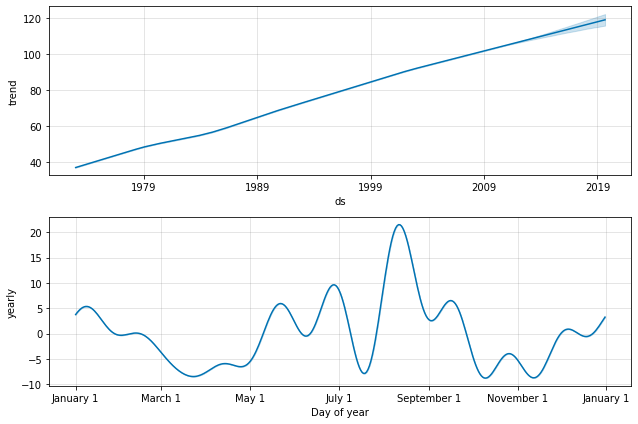

In [72]:
my_model_add.plot_components(forecast);

In [73]:
error_metrics = get_error_metrics('FB_prophet_additive', test, forecast['yhat'][-113:], error_metrics)
error_metrics

,Method,MSE,RMSPE,MAPE
0,Holtz winter Additive,65.187008,0.822590,0.069322
1,Holtz winter Multiplicative Damped,8.388454,0.277690,0.022729
2,ARIMA,42.276840,0.595184,0.047916
3,SARIMA,26.647524,0.533783,0.044863
4,STL_arima,12.096118,0.322460,0.025761
5,FB_prophet_multiplicative,120.075556,1.113683,0.099623
6,FB_prophet_additive,139.082260,1.242367,0.106345


## Conclusion <a id = 'conclusion'><a/><div style="text-align: right;"><a href='#toc'>Back to contents<a/></div>

## [Holtz winter Multiplicative Damped](#ets_mult) seems to have overperformed the other models by a wide margin, so we have a winner here 🎊 🎉
- Also worth noting here that AIC for this model is also pretty Low, compared to it's 